In [2]:
import sys
print(sys.version_info)
assert sys.version_info >= (3, 7)

from packaging import version
import sklearn
print ("Scikit-Learn version: ", sklearn.__version__)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

sys.version_info(major=3, minor=11, micro=4, releaselevel='final', serial=0)
Scikit-Learn version:  1.3.0


In [3]:
import matplotlib.pyplot as plt

def plot_digit(image_data, axis=False):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")

    if not axis:
        plt.axis("off")

In [4]:
def plot_multi(img,start=0,end=100):
    plt.figure(figsize=(9, 9))
    for idx, image_data in enumerate(img[start:end]):
        plt.subplot(10, 10, idx + 1)
        plot_digit(image_data)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

## data preparation

In [5]:
from pathlib import Path

# this is where the datasets are located
path = Path() / "dataset_cleaned"
print(path)

dataset_cleaned


In [6]:
my_data_num = np.load(path / "digit_data_TrVal_corrected.npz")
my_data_sym = np.load(path / "op_data_TrVal_corrected.npz")

## thickening using cv2

there's a method using **cv2.dilate()** that can increase the area, which will generate a thicker line

I have no idea how this works, but let's try to our data
code [here](https://stackoverflow.com/questions/46895772/thicken-a-one-pixel-line)

(28, 28)


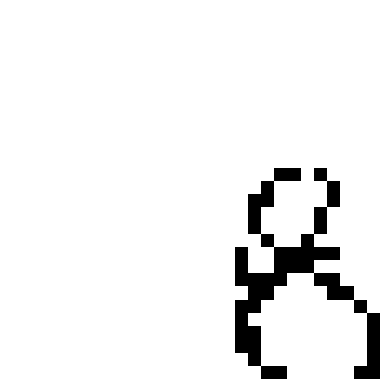

In [7]:
sample = my_data_num["img"][6]
plot_digit(sample)
print(sample.shape)

In [8]:
import cv2

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
dilate = cv2.dilate(sample,kernel,iterations=1)

In [9]:
dilate.shape

(28, 28)

In [10]:
dilate.dtype

dtype('float64')

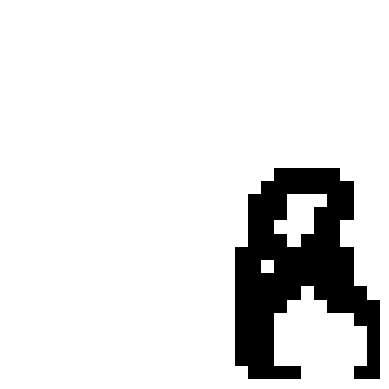

In [11]:
plot_digit(dilate)

not bad, but as our data is 28 * 28, the result is kinda large

let's try the **MORPH_ELLIPSE** also

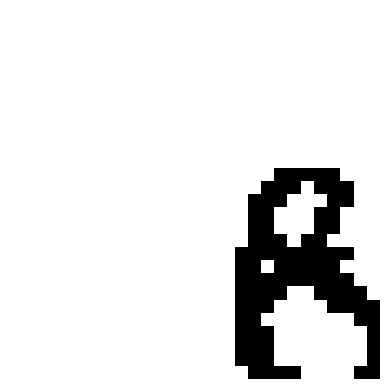

In [12]:
kernel_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
dilate_ellipse = cv2.dilate(sample,kernel_ellipse,iterations=1)
plot_digit(dilate_ellipse)

a bit better!

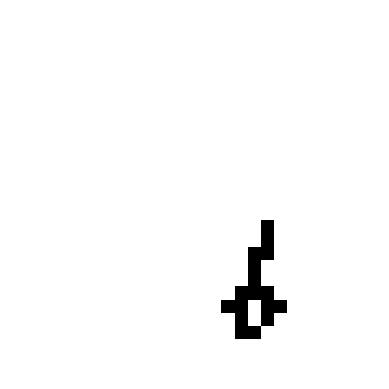

In [13]:
sample_thin = my_data_num["img"][9]
plot_digit(sample_thin)

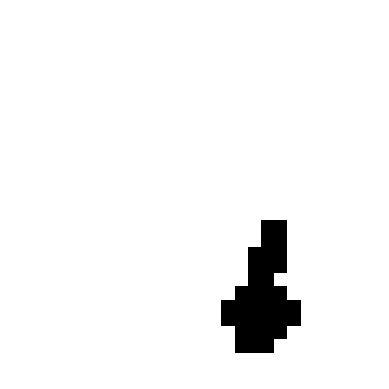

In [14]:
dilate_thin = cv2.dilate(sample_thin,kernel,iterations=1)
plot_digit(dilate_thin)

in this case, it kinda ruined the img, so determining whether the img needs **dilate()** would be crucial

## resize

while searching, i found the **cv2.resize()** which can resize into whatever I want. let's have a try

so get the boundary(like in **rebase()**), then resize that part

In [15]:
r = 28
c = 28

# each boundary
r_top = r
r_bot = -1
c_left = c
c_right = -1

for n in range(r):
    for m in range(c):
        
        # if the pixel has whatever value
        if sample_thin[n][m] != 0:
            # update the boundary
            r_top = min(r_top, n)
            r_bot = max(r_bot, n)
            c_left = min(c_left, m)
            c_right = max(c_right, m)

In [16]:
print(r_top,r_bot,c_left,c_right)

16 24 16 20


In [17]:
asdf = sample_thin[16:25,16:21]

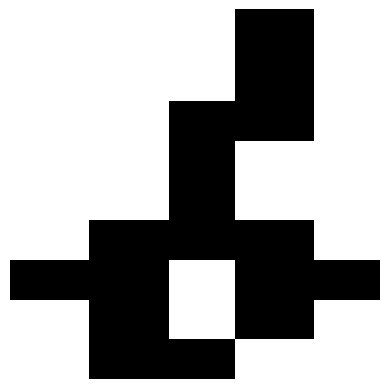

cv2.INTER_NEAREST


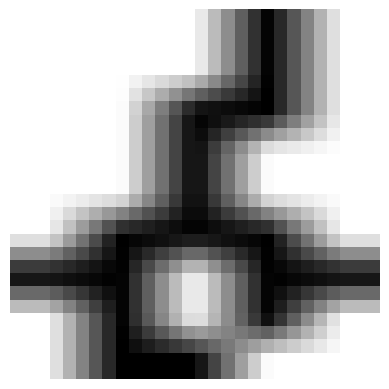

cv2.INTER_LINEAR


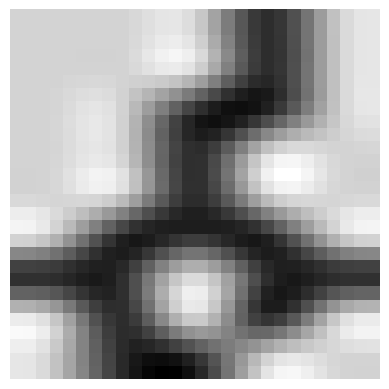

cv2.INTER_LINEAR_EXACT


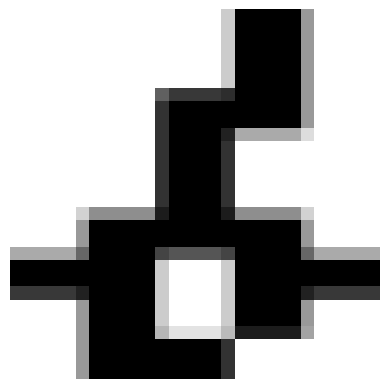

cv2.INTER_CUBIC


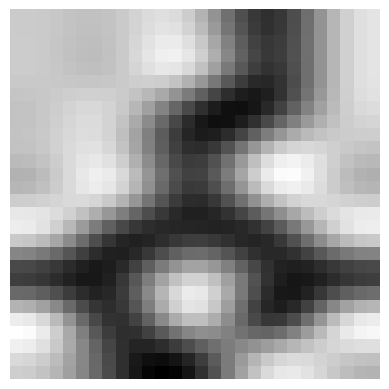

cv2.INTER_AREA


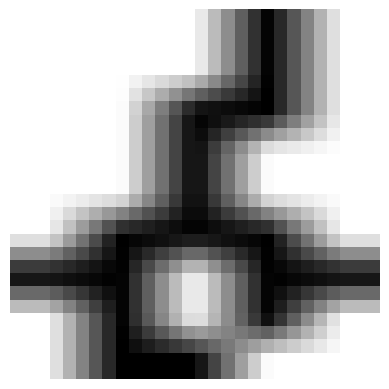

cv2.INTER_LANCZOS4


In [18]:
interpol = np.array(["cv2.INTER_NEAREST","cv2.INTER_LINEAR","cv2.INTER_LINEAR_EXACT","cv2.INTER_CUBIC","cv2.INTER_AREA","cv2.INTER_LANCZOS4"])

for i, hp in enumerate(interpol):
    dst = cv2.resize(asdf, dsize=(28,28),interpolation=i)
    plot_digit(dst)
    plt.show()
    print(hp)

cubic or nearest would be our choice here, let's resize into smaller ones

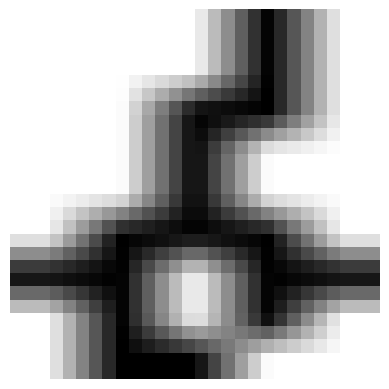

In [19]:
plot_digit(dst)

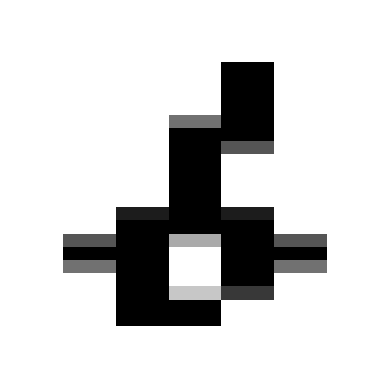

In [20]:
dst_small = cv2.resize(asdf, dsize=(20,20),interpolation=3)
dst_small = np.pad(dst_small,4,mode="constant")
plot_digit(dst_small)

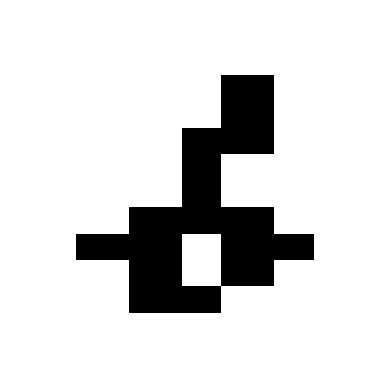

In [21]:
dst_small = cv2.resize(asdf, dsize=(18,18),interpolation=0)
dst_small = np.pad(dst_small,5,mode="constant")
plot_digit(dst_small)

better, let's make this into a function

In [22]:
def resize(img,size=18):
    r = 28
    c = 28
    
    # each boundary
    r_top = r
    r_bot = -1
    c_left = c
    c_right = -1
    
    for n in range(r):
        for m in range(c):
            
            # if the pixel has whatever value
            if img[n][m] != 0:
                # update the boundary
                r_top = min(r_top, n)
                r_bot = max(r_bot, n)
                c_left = min(c_left, m)
                c_right = max(c_right, m)
                
    import cv2
    
    # using inter_nearest
    resized_img = cv2.resize(img[r_top:r_bot+1,c_left:c_right+1], dsize=(size,size),interpolation=0)
    resized_img = np.pad(resized_img,int((28 - size)/2),mode="constant")
    
    return resized_img

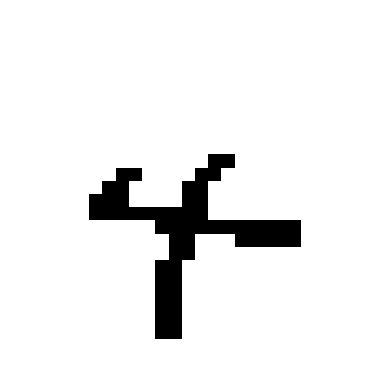

In [23]:
final_test_sample = my_data_num["img"][13]
plot_digit(final_test_sample)

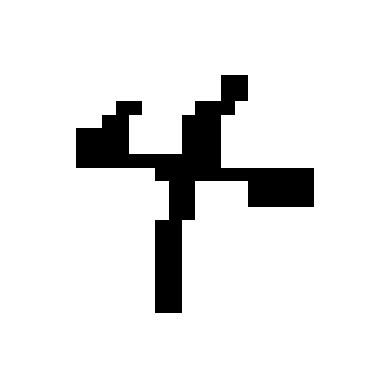

In [24]:
plot_digit(resize(final_test_sample))

this also does the rebase thing, as it centers into middle

In [25]:
data = my_data_num["img"]
size = data.shape[0]

for i in range(size):
    data[i] = resize(data[i])
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


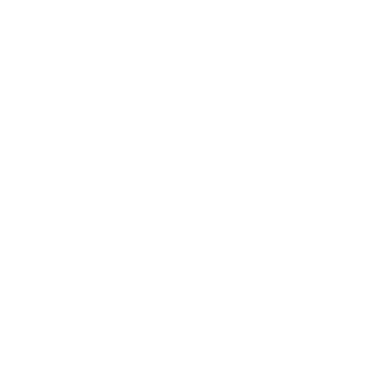

In [26]:
plot_digit(my_data_num["img"][1448])

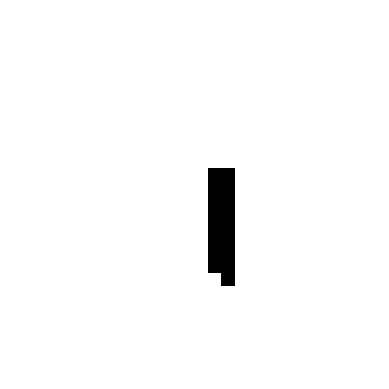

In [29]:
sample_error = my_data_num["img"][141]
plot_digit(sample_error)

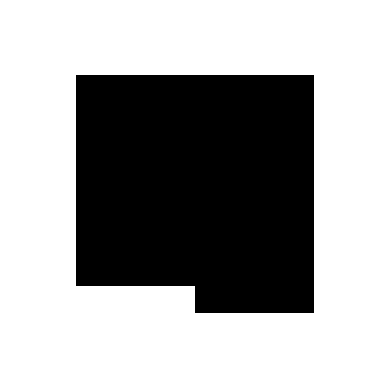

In [30]:
plot_digit(resize(sample_error))

In [46]:
def resize_fixed(img,size=18):
    r = 28
    c = 28
    
    # each boundary
    r_top = r
    r_bot = -1
    c_left = c
    c_right = -1
    
    for n in range(r):
        for m in range(c):
            
            # if the pixel has whatever value
            if img[n][m] != 0:
                # update the boundary
                r_top = min(r_top, n)
                r_bot = max(r_bot, n)
                c_left = min(c_left, m)
                c_right = max(c_right, m)
                
    row_len = r_bot - r_top + 1
    col_len = c_right - c_left + 1
    
    adjusted_img = img[r_top:r_bot+1,c_left:c_right+1]
    
    diff = abs(row_len - col_len)
    
    top_pad = int(diff / 2)
    down_pad = int(diff / 2)
    
    if diff % 2 == 1:
        top_pad += 1
    
    if row_len > col_len:
        adjusted_img = np.pad(adjusted_img, pad_width=((0,0),(top_pad,down_pad)), mode="constant")
            
    else:
        adjusted_img = np.pad(adjusted_img, pad_width=((top_pad,down_pad),(0,0)), mode="constant")        
        

    import cv2
    
    try:
        # using inter_nearest
        resized_img = cv2.resize(adjusted_img, dsize=(size,size),interpolation=0)
    except:
        return img
    
    resized_img = np.pad(resized_img,int((28 - size)/2),mode="constant")
    
    return resized_img

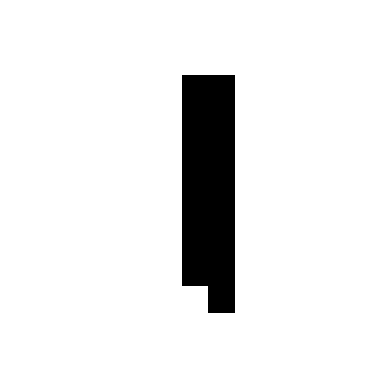

In [47]:
plot_digit(resize_fixed(sample_error))

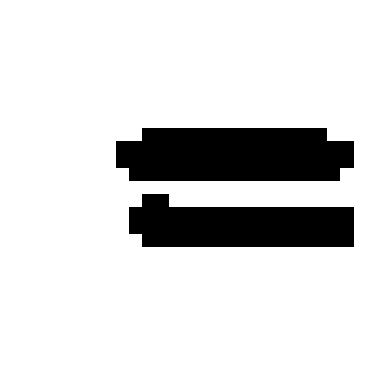

In [48]:
sample_sym = my_data_sym["img"][0]
plot_digit(sample_sym)

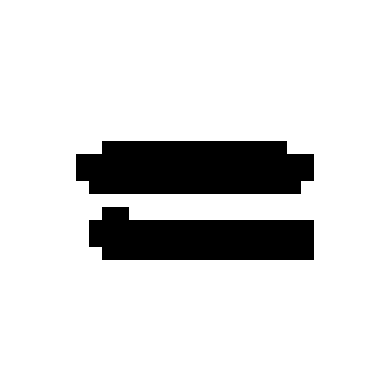

In [49]:
plot_digit(resize_fixed(sample_sym))